In [155]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display_markdown, display, Audio

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

import os
from pathlib import Path
from typing import Dict

%cd ..
from models import RNN, CNN, ConvolutionalRNN, ConvolutionalTransformer, VisionTransformer
from preprocess import create_transform, invert_log_filter_spectrogram
from evaluate import compute_peaks
%cd notebooks

plt.style.use('ggplot')
study_path = Path(os.getcwd()).parent.resolve() / "study"
device = "cpu"

/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis
/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis/notebooks


/Users/runarfosse/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [156]:
# Declare every model and dataset
models = [RNN, CNN, ConvolutionalRNN, ConvolutionalTransformer, VisionTransformer]
datasets = ["ENST+MDB", "EGMD", "SLAKH", "ADTOF-YT"]
expanded_datasets = datasets + ["SADTP"]

In [157]:
# Declare helper functions
def extract_architecture_performances(study: Path, model: str) -> Dict[str, float]:
    path = study / model
    if not path.exists():
        return {}

    performances = {}
    for dataset in path.iterdir():
        if dataset.is_dir() and not dataset.name.startswith("."):
            with open(dataset / "results.txt") as f:
                performances[dataset.name] = round(float(f.readlines()[6].split(" ")[-1].strip()), 2)
    
    return performances

def extract_dataset_performances(study: Path, model: str) -> Dict[str, float]:
    path = study / model
    if not path.exists():
        return {}

    performances = {}
    for train_dataset in path.iterdir():
        if train_dataset.is_dir() and not train_dataset.name.startswith("."):
            performances[train_dataset.name] = {}
            with open(train_dataset / "tests.txt") as f:
                lines = f.readlines()
                for i in range(len(lines) // 4):
                    test_dataset = lines[i * 4].split(" ")[4].replace("_", "-")
                    performance = round(float(lines[i * 4 + 1].split(" ")[-1].strip()), 2)
                    performances[train_dataset.name][test_dataset] = performance
    
    return performances

# Analysis of the Architecture study

### Analyse the different models" performance on different datasets

In [158]:
# Compute the different performances
architecture_path = study_path / "Architecture"

architecture_performances = {model: extract_architecture_performances(architecture_path, model.name) for model in models}

In [159]:
# Find and print their respective performances
markdown = "## Architecture study performances\n"
markdown += f"| Model | {'|'.join(datasets)} |\n"
markdown += f"|:--|{'--:|'.join('' for _ in datasets)}--:|\n"

for model in models:
    markdown += f"|{model.name}|"
    for dataset in datasets:
        if model in architecture_performances and dataset in architecture_performances[model]:
            performance = architecture_performances[model][dataset]
            if performance == max(architecture_performances[m][dataset] for m in models):
                markdown += f"**{performance}**|"
            else:
                markdown += f"{performance}|"
        else:
            markdown += "|"
    markdown += "\n"

display_markdown(markdown, raw=True)

## Architecture study performances
| Model | ENST+MDB|EGMD|SLAKH|ADTOF-YT |
|:--|--:|--:|--:|--:|
|RNN|0.67|**0.9**|0.86|**0.96**|
|CNN|0.78|0.88|0.83|0.84|
|Convolutional RNN|**0.81**|**0.9**|**0.9**|0.93|
|Convolutional Transformer|0.78|0.89|0.88|0.95|
|Vision Transformer|0.54|0.89|0.88|**0.96**|


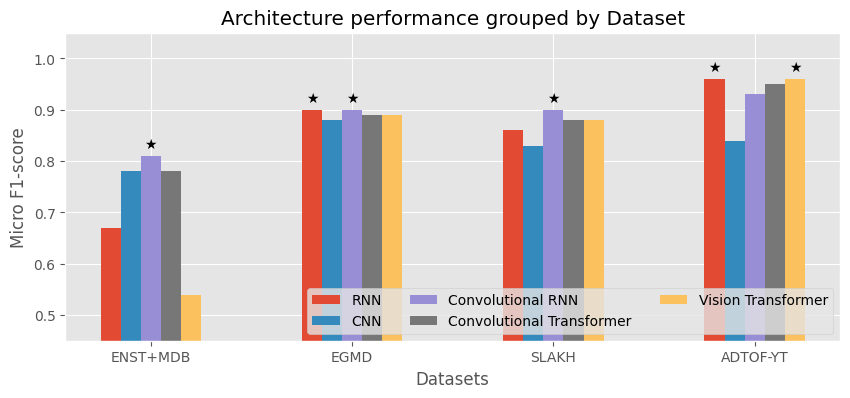

In [160]:
# Plot performances
x = np.arange(len(datasets))
width = 0.1
multiplier = -1

fig, ax = plt.subplots(figsize=(10, 4))
for model in models:
    performances = [architecture_performances[model][dataset] for dataset in datasets]
    offset = width * multiplier
    rects = ax.bar(x + offset, performances, width, label=model.name)
    
    bar_labels = ["★" if architecture_performances[model][dataset] == max(architecture_performances[m][dataset] for m in models) else "" for dataset in datasets]
    ax.bar_label(rects, bar_labels, padding=3)
    multiplier += 1
    
ax.set_ylabel("Micro F1-score")
ax.set_xlabel("Datasets")
ax.set_title("Architecture performance grouped by Dataset")
ax.set_xticks(x + width, datasets)
ax.set_ylim(0.45, 1.05)
ax.legend(bbox_to_anchor=(1.0, 0.0), loc="lower right", ncols=3)
plt.savefig("../thesis/figures/architectureperformancedataset.png", bbox_inches='tight')
plt.show()

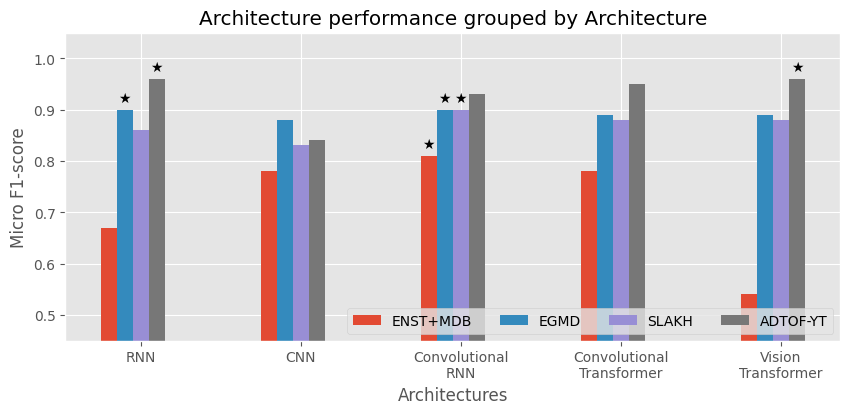

In [161]:
# Plot performances
x = np.arange(len(models))
width = 0.1
multiplier = -1

fig, ax = plt.subplots(figsize=(10, 4))
for dataset in datasets:
    performances = [architecture_performances[model][dataset] for model in models]
    offset = width * multiplier
    rects = ax.bar(x + offset, performances, width, label=dataset)

    bar_labels = ["★" if performance == max(performances) else "" for performance in performances]
    ax.bar_label(rects, bar_labels, padding=3)
    multiplier += 1
    
ax.set_ylabel("Micro F1-score")
ax.set_xlabel("Architectures")
ax.set_title("Architecture performance grouped by Architecture")
ax.set_xticks(x + width, [model.name.replace(" ", "\n") for model in models])
ax.set_ylim(0.45, 1.05)
ax.legend(bbox_to_anchor=(1.0, 0.0), loc="lower right", ncols=4)
plt.savefig("../thesis/figures/architectureperformancearchitecture.png", bbox_inches='tight')
plt.show()

### Visualize the Convolutional Recurrent Neural Network's performance on each dataset

Visualized on the test split, to gauge visual performance on unseen data. If we had visualized validation data our models would perform better than expected, due to the introduced bias from model selection (by selecting the best performer on the validation split).

In [162]:
dataset_path = study_path.parent / "data"
dataset_paths = {
    "ENST+MDB": dataset_path / "ENST+MDB",
    "EGMD": dataset_path / "e-gmd-v1.0.0",
    "SLAKH": dataset_path / "slakh2100_flac_redux",
    "ADTOF-YT": dataset_path / "adtof",
}

def plot_prediction(model: nn.Module, data: torch.Tensor, label: torch.Tensor, transforms: Compose) -> None:
    # Predict using the model
    with torch.no_grad():
        if transforms:
            data = transforms(data)
        activation = F.sigmoid(model(data))
        prediction = compute_peaks(activation).round()

    # And plot
    fig, ax = plt.subplots(3)

    ax[0].set_title("Data (400 frames, 84 bins, 1 channel)")
    ax[0].imshow(data.squeeze().T)
    ax[0].set_xlabel("Frames (hop size: 10ms)")
    ax[0].set_ylabel("Frequency bins")
    ax[0].invert_yaxis()
    ax[0].grid(False)

    ax[1].set_title("Target (400 frames, 5 classes)")
    ax[1].imshow(label.squeeze().T.round(), aspect=10, interpolation="nearest")
    ax[1].set_xlabel("Frames (hop size: 10ms)")
    ax[1].set_ylabel("Classes")
    ax[1].set_yticks([0, 1, 2, 3, 4], ("BD", "SD", "TT", "HH", "CY+RD"))
    ax[1].invert_yaxis()
    ax[1].grid(False)

    ax[2].set_title("Prediction (400 frames, 5 classes)")
    ax[2].imshow(prediction.squeeze().T, aspect=10, interpolation="nearest")
    ax[2].set_xlabel("Frames (hop size: 10ms)")
    ax[2].set_ylabel("Classes")
    ax[2].set_yticks([0, 1, 2, 3, 4], ("BD", "SD", "TT", "HH", "CY+RD"))
    ax[2].invert_yaxis()
    ax[2].grid(False)

    fig.tight_layout()
    plt.show()

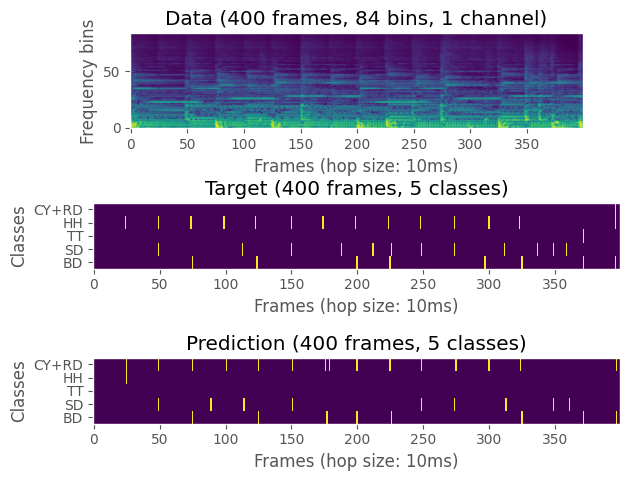

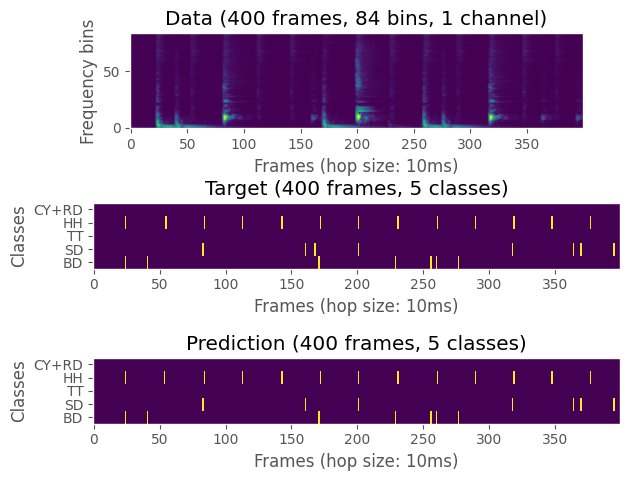

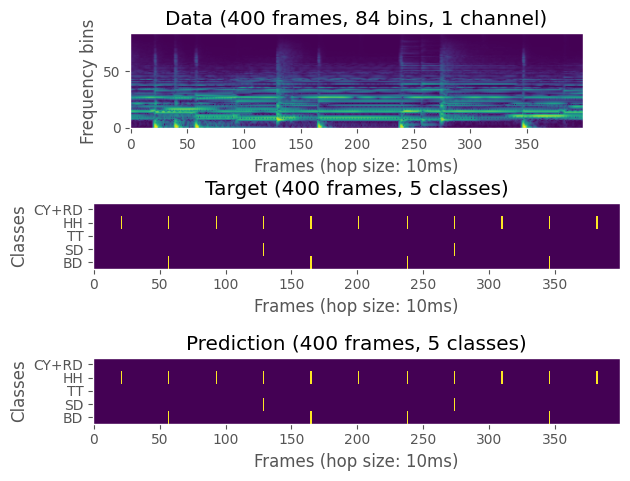

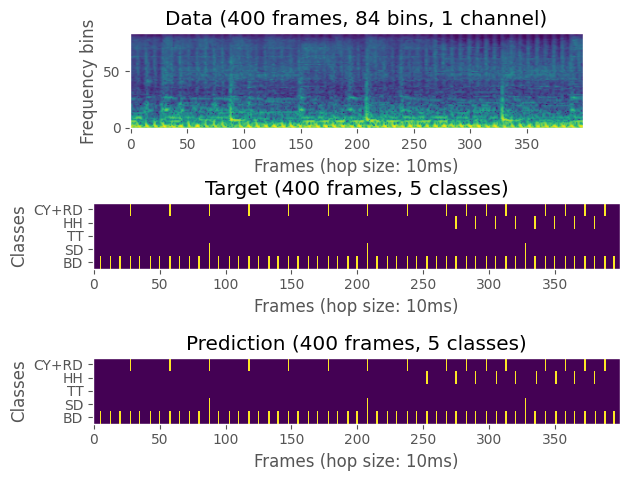

In [163]:
seed = 0

# For each of the datasets
for dataset in datasets:
    # Load the model
    model_path = architecture_path / "Convolutional RNN" / dataset
    state_dict, config = torch.load(model_path / "model.pt", map_location=device), torch.load(model_path / "config.pt", map_location=device)
    model = config["Model"](**config["parameters"]).to(device)
    model.load_state_dict(state_dict)
    transform = create_transform(**config["transforms"], channels_last=True)

    # And a corresponding, random test datapoint (to represent unseen data)
    torch.manual_seed(seed)
    dataset = dataset_paths[dataset] / (dataset.lower().replace("-","_") + "_test.pt")
    if not dataset.exists():
        print(dataset.name, "missing.")
        continue
    test_loader = DataLoader(torch.load(dataset, map_location=device), shuffle=True, batch_size=1)
    spectrogram, annotation = next(iter(test_loader))
    spectrogram, annotation = spectrogram.to(device), annotation.to(device)
    
    # Approximate and display the original audio waveform
    waveform = invert_log_filter_spectrogram(spectrogram[0].squeeze(dim=(0, -1)).T)
    display(Audio(waveform, rate=44100))

    # Display its spectrogram and annotation, and models' prediction
    plot_prediction(model, spectrogram, annotation, transform)


# Analysis of the Dataset study

### Analyse a model"s performance on different datasets, based on a separate training dataset

In [164]:
# Compute the different performances
dataset_path = study_path / "Dataset"

dataset_performances = (extract_dataset_performances(architecture_path, "Convolutional RNN")
                       | extract_dataset_performances(dataset_path, "Convolutional RNN"))

In [165]:
# Find and print their respective performances
markdown = "## Dataset study performances\n"
markdown += f"| Model | {'|'.join(expanded_datasets)} |\n"
markdown += f"|:--|{'--:|'.join('' for _ in expanded_datasets)}--:|\n"

for training_dataset, performances in dataset_performances.items():
    markdown += f"|{training_dataset}|"
    for dataset in expanded_datasets:
        if training_dataset in dataset_performances and dataset in dataset_performances[training_dataset]:
            performance = dataset_performances[training_dataset][dataset]
            if dataset in training_dataset:
                if performance == max(dataset_performances[t][dataset] for t in dataset_performances.keys() if dataset in t):
                    markdown += f"***{performance}***|"
                else:
                    markdown += f"*{performance}*|"
            else:
                if performance == max(dataset_performances[t][dataset] for t in dataset_performances.keys() if dataset not in t):
                    markdown += f"**{performance}**|"
                else:
                    markdown += f"{performance}|"
        else:
            markdown += "|"
    markdown += "\n"

display_markdown(markdown, raw=True)

## Dataset study performances
| Model | ENST+MDB|EGMD|SLAKH|ADTOF-YT|SADTP |
|:--|--:|--:|--:|--:|--:|
|EGMD|0.55|***0.9***|0.44|0.42|0.28|
|SLAKH|0.8|0.73|***0.9***|0.59|0.48|
|ENST+MDB|*0.81*|0.59|0.53|0.6|0.42|
|ADTOF-YT|0.84|0.69|**0.65**|*0.93*|0.61|
|EGMD+SLAKH+ADTOF-YT|0.85|***0.9***|*0.89*|*0.93*|0.61|
|ENST+MDB+SLAKH+ADTOF-YT|***0.88***|**0.74**|*0.89*|*0.95*|0.61|
|SLAKH+ADTOF-YT|**0.86**|0.72|***0.9***|***0.96***|**0.62**|
|ENST+MDB+ADTOF-YT|*0.86*|0.7|0.63|*0.94*|**0.62**|
|ENST+MDB+EGMD+SLAKH+ADTOF-YT|*0.87*|*0.89*|***0.9***|*0.93*|**0.62**|
|ENST+MDB+SLAKH|*0.84*|0.73|***0.9***|**0.63**|0.47|


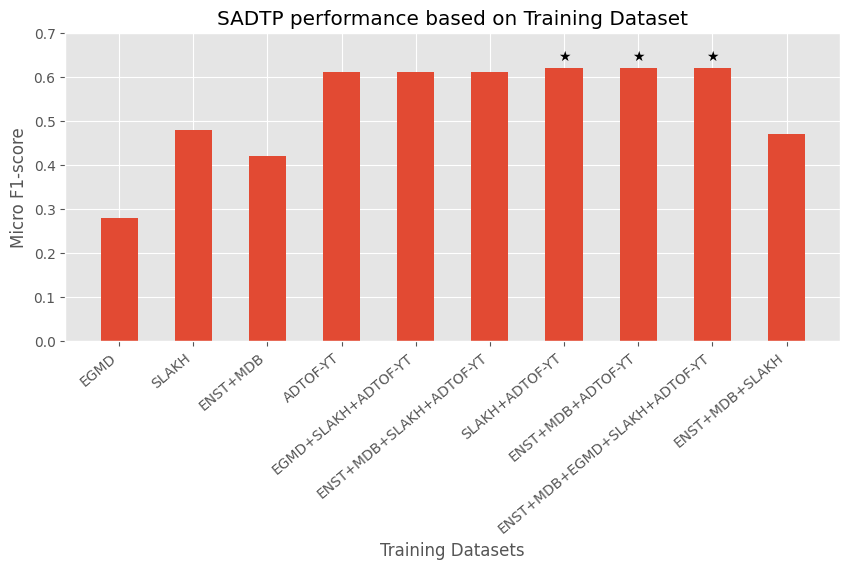

In [166]:
# Plot performances on SADTP
x = np.arange(len(dataset_performances))
width = 0.5
fig, ax = plt.subplots(figsize=(10, 4))
performances = [performance["SADTP"] for performance in dataset_performances.values()]
rects = ax.bar(x, performances, width, label=dataset_performances.keys())
    
bar_labels = ["★" if performance["SADTP"] == max(perf["SADTP"] for perf in dataset_performances.values()) else "" for performance in dataset_performances.values()]
ax.bar_label(rects, bar_labels, padding=3)
    
ax.set_ylabel("Micro F1-score")
ax.set_xlabel("Training Datasets")
ax.set_title("SADTP performance based on Training Dataset")
ax.set_xticks(x, dataset_performances.keys())
ax.set_xticklabels(dataset_performances.keys(), rotation=40, ha="right")
ax.set_ylim(0.0, 0.7)
#ax.legend(bbox_to_anchor=(1.0, 0.0), loc="lower right", ncols=3)
plt.savefig("../thesis/figures/datasetperformancesadtp.png", bbox_inches='tight')
plt.show()

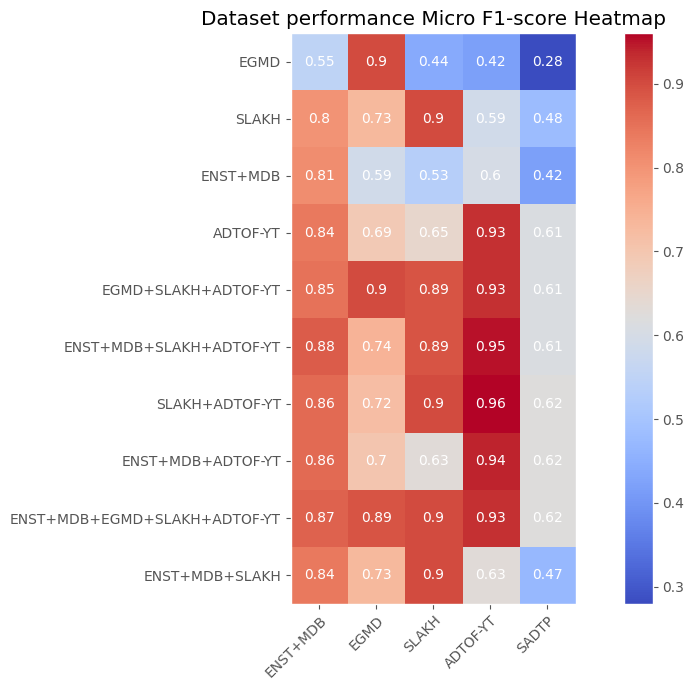

In [167]:
# Plot performances as a heatmap
fig, ax = plt.subplots(figsize=(10, 7))

heatmap = [list(performances.values()) for _, performances in dataset_performances.items()]
rows = [training_dataset for training_dataset in dataset_performances.keys()]
columns = list(list(dataset_performances.values())[0].keys())

image = ax.imshow(heatmap, cmap="coolwarm")
plt.colorbar(image)

ax.set_xticks(range(len(columns)), labels=columns,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(rows)), labels=rows)

# Loop over data dimensions and create text annotations.
for i in range(len(rows)):
    for j in range(len(columns)):
        text = ax.text(j, i, heatmap[i][j],
                       ha="center", va="center", color="w")

ax.set_title("Dataset performance Micro F1-score Heatmap")
ax.grid(False)
plt.tight_layout()
plt.show()